In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Scaler
import ELPH_Optimizer

from ELPH_NVAR import SVDNVAR

In [15]:
runs = ELPH_utils.load_runs()

runs_w002 = ELPH_utils.load_runs(filename='../runs_w0.02.npz')
runs_w003 = ELPH_utils.load_runs(filename='../runs_w0.03.npz')
runs_w01 = ELPH_utils.load_runs(filename='../runs_w0.1.npz')

runs = runs[:] + runs_w002[:] + runs_w003 + runs_w01


n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

# for k in range(len(runs)):
#     runs[k] = runs[k][:,:200:2]

400 loaded with n_kmax = 80


runs[0] shape:  (80, 400)


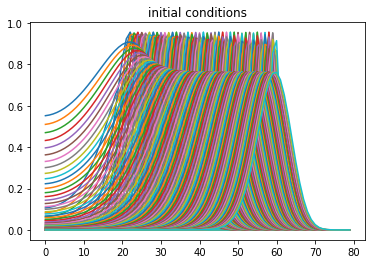

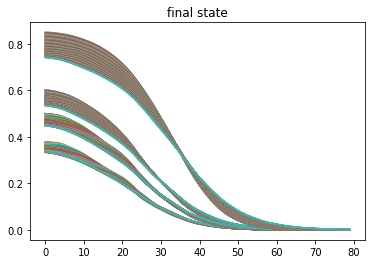

In [16]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()


for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('final state')
plt.show()

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 159600)
NVAR state shape:  (861, 159600)
target shape:  (20, 159600)
weights shape:  (861, 20)


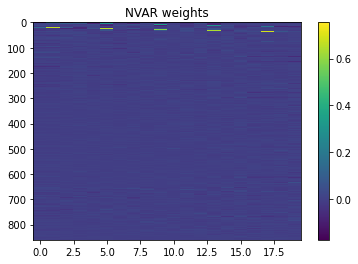

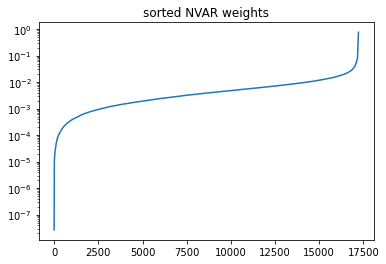

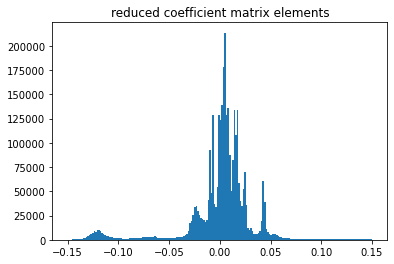

In [17]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)

# scaler = ELPH_Scaler.standardize_scaler()
scaler = ELPH_Scaler.normalize_scaler(0.3)
# scaler = ELPH_Scaler.tanh_scaler(arg_scale=1.0, out_scale=0.3)

NVAR = SVDNVAR(runs)
NVAR.train(rdim=20, n_VAR_steps=2, NVAR_p=2, intercept=True, optimizer=optimizer, scaler=scaler)
NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(NVAR.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(NVAR.red_coef_matrix), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

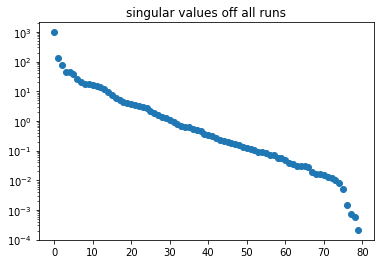

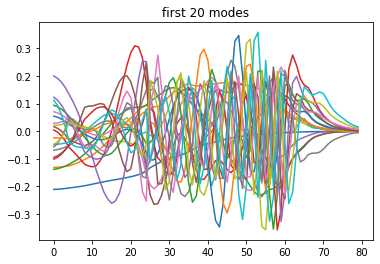

In [18]:
plt.semilogy(NVAR.S, 'o')
plt.title('singular values off all runs')
plt.show()
 
for l in range(NVAR.rdim):
  plt.plot(NVAR.U[:,l],  label='Uhat_'+str(l))
plt.title('first ' + str(NVAR.rdim) + ' modes')
plt.show()

In [19]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)
scaler = ELPH_Scaler.normalize_scaler(0.3)

train_kwargs = {'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'intercept':True, 'optimizer':optimizer, 'scaler':scaler, 'full_hist':False}
score_kwargs = {'norm':'max', 'errSVD':True}

m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.014958817020470448
0.0010183986642883364
[0.013776715494652897, 0.013819912934535017, 0.015082400875187677, 0.016233039301077938, 0.01588201649689871]


In [22]:
def get_score(aExp, rel_scale):
    alpha = 10.0**aExp
    
    scaler = ELPH_Scaler.normalize_scaler(rel_scale)
    optimizer = ELPH_Optimizer.ridge(alpha=alpha)
    
    train_kwargs = {'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'intercept':True, 'optimizer':optimizer, 'scaler':scaler, 'full_hist':False}
    score_kwargs = {'norm':'max', 'errSVD':True}
    
    m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    
    r = -1.*m - 1.*np.std(s)
    if np.isnan(r):
        r = -10.0
    return r

# print(get_score(-3.4, 0.1))

from bayes_opt import BayesianOptimization
pbounds = {'aExp':[-5, -1], 'rel_scale':[0.1,0.7]}
optimizer = BayesianOptimization(f=get_score, pbounds=pbounds, random_state=817)

optimizer.maximize(init_points=10, n_iter=60)

|   iter    |  target   |   aExp    | rel_scale |
-------------------------------------------------
|  1        | -0.01612  | -3.007    |  0.2551   |
|  2        | -0.02141  | -4.485    |  0.2465   |
|  3        | -0.01632  | -2.094    |  0.4818   |
|  4        | -0.01576  | -2.661    |  0.3431   |
|  5        | -0.02054  | -3.044    |  0.1049   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_NVAR.py:143: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec


|  6        | -10.0     | -3.43     |  0.6277   |
|  7        | -0.01414  | -2.31     |  0.6173   |
|  8        | -0.0149   | -2.332    |  0.5143   |
|  9        | -0.01333  | -3.123    |  0.4563   |
|  10       | -0.01649  | -2.053    |  0.4857   |
|  11       | -0.01564  | -2.661    |  0.3505   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_NVAR.py:143: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec


|  12       | -10.0     | -5.0      |  0.5827   |
|  13       | -0.04688  | -1.36     |  0.1      |
|  14       | -0.02229  | -1.247    |  0.7      |
|  15       | -0.03795  | -1.0      |  0.3096   |
|  16       | -0.01334  | -3.122    |  0.4562   |
|  17       | -0.01742  | -4.12     |  0.1035   |
|  18       | -0.03007  | -1.874    |  0.1      |
|  19       | -0.01701  | -1.635    |  0.6993   |
|  20       | -0.02412  | -2.293    |  0.1056   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_NVAR.py:143: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec


|  21       | -10.0     | -4.253    |  0.6919   |
|  22       | -0.0196   | -3.442    |  0.1      |
|  23       | -0.01568  | -4.689    |  0.1      |
|  24       | -0.02311  | -1.511    |  0.3914   |
|  25       | -0.01645  | -4.399    |  0.1038   |
|  26       | -0.02965  | -1.0      |  0.7      |
|  27       | -0.01266  | -2.706    |  0.7      |
|  28       | -0.0772   | -1.0      |  0.1      |
|  29       | -0.01464  | -2.205    |  0.6022   |
|  30       | -0.01857  | -3.807    |  0.1013   |
|  31       | -0.03598  | -1.627    |  0.1004   |
|  32       | -0.01593  | -3.223    |  0.23     |
|  33       | -0.02251  | -2.591    |  0.1012   |
|  34       | -0.01527  | -1.897    |  0.7      |
|  35       | -0.02796  | -1.235    |  0.4151   |
|  36       | -0.02084  | -1.777    |  0.3507   |
|  37       | -0.02126  | -2.078    |  0.2233   |
|  38       | -0.01307  | -2.519    |  0.7      |
|  39       | -0.02704  | -1.578    |  0.1873   |
|  40       | -0.01821  | -2.426    |  0.2714   |


In [8]:
# scores = []

# k = 1

# for aExp in np.linspace(-4,-2,15):
#     for rs in np.linspace(0.2,0.5,15):
#         print(k)
#         scores.append(get_score(aExp,rs))
#         k += 1

In [9]:
# scrs = np.array(scores)
# scrs = np.reshape(scrs,(15,15))


# plt.imshow(scrs, aspect='auto', origin='lower', vmin=-0.02, extent=[0.2,0.5,-4,-2])
# plt.colorbar()
# plt.show()

rdim:  10
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (20, 159201)
NVAR state shape:  (231, 159201)
target shape:  (10, 159201)
weights shape:  (231, 10)
NVAR error:  0.038134997840941764
NVAR error compared to SVD approximated run:  0.012911168059256073


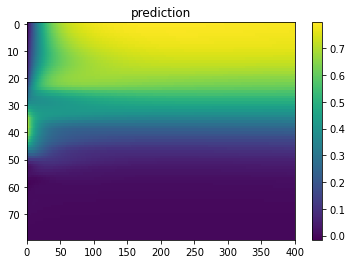

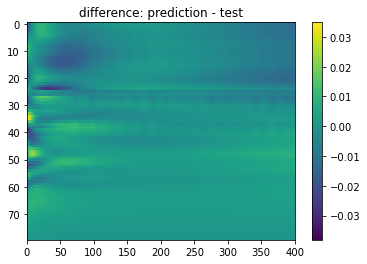

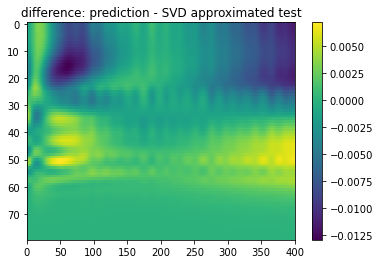

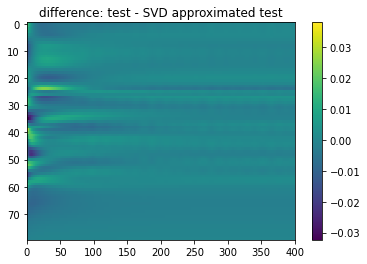

In [21]:
scaler = ELPH_Scaler.normalize_scaler(0.3)
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)
# optimizer = ELPH_Optimizer.lstsqrs()


train_runs = runs[::1]
test_run = train_runs.pop(332)

NVAR.load_runs(train_runs)
NVAR.train(rdim=10, n_VAR_steps=2, NVAR_p=2, intercept=True, optimizer=optimizer, scaler=scaler, full_hist=False)

NVAR.print_status()


print('NVAR error: ', NVAR.get_error(test_run, norm='max') )
print('NVAR error compared to SVD approximated run: ', NVAR.get_error(test_run, norm='max', errSVD=True) )

pred = NVAR.predict_single_run(test_run)
test_run_SVDapprx = NVAR.Uhat @ NVAR.Uhat.T @ test_run


xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

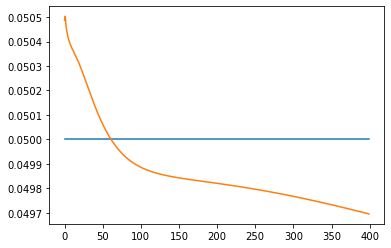

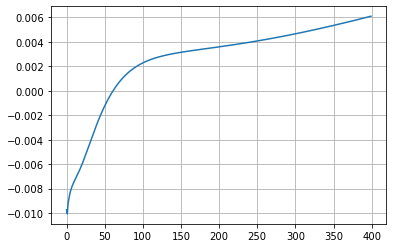

In [11]:
import ELPH_dyn

N_test = np.sum(test_run, axis=0)
N_pred = np.sum(pred, axis=0)

dk = 4./80.

def get_N(run):
    Narr = np.zeros(run.shape[1])
    for t in range(run.shape[1]):
        N = 0
        for k in range(run.shape[0]):
            N += run[k,t] * ELPH_dyn.get_k(dk,k)*dk/2./np.pi
        Narr[t] = N
        
    return Narr

N_test_noPI = get_N(test_run)
N_pred_noPI = get_N(pred)

plt.plot(N_test_noPI)
plt.plot(N_pred_noPI)
plt.show()

plt.grid()
plt.plot((N_test_noPI-N_pred_noPI)/N_test_noPI)
plt.show()

ridge regression loss: 0.9604002
epoch: 1 loss: 0.9660736
epoch: 2 loss: 0.9608735
epoch: 3 loss: 0.95961285
epoch: 4 loss: 0.95957816
epoch: 5 loss: 0.9592213
epoch: 6 loss: 0.95859486
epoch: 7 loss: 0.9603469
epoch: 8 loss: 0.961519
epoch: 9 loss: 0.9574282
epoch: 10 loss: 0.95722383
epoch: 11 loss: 0.9580467
epoch: 12 loss: 0.9560666
epoch: 13 loss: 0.9564209
epoch: 14 loss: 0.9561666
epoch: 15 loss: 0.9548479
epoch: 16 loss: 0.95496583
epoch: 17 loss: 0.95445204
epoch: 18 loss: 0.9542878
epoch: 19 loss: 0.9538675
epoch: 20 loss: 0.95338774
epoch: 21 loss: 0.9578916
epoch: 22 loss: 0.95484257
epoch: 23 loss: 0.95402616
epoch: 24 loss: 0.9522813
epoch: 25 loss: 0.9513583
epoch: 26 loss: 0.95553184
epoch: 27 loss: 0.9509628
epoch: 28 loss: 0.9516936
epoch: 29 loss: 0.95108485
epoch: 30 loss: 0.9516494
epoch: 31 loss: 0.9508808
epoch: 32 loss: 0.95017093
epoch: 33 loss: 0.9489645
epoch: 34 loss: 0.9485975
epoch: 35 loss: 0.94996226
epoch: 36 loss: 0.95283276
epoch: 37 loss: 0.9480046
e

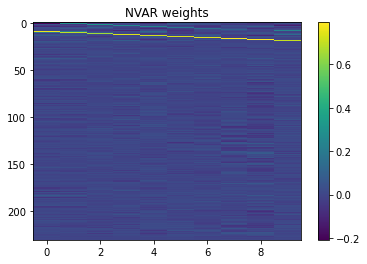

In [12]:
scaler = ELPH_Scaler.normalize_scaler(0.3)
# optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)
optimizer = ELPH_Optimizer.PIML_adam(alpha=10.**-2.8, lambda1=100, epochs = 100, mini_batch_size = 5000)

train_runs = runs[::1]
test_run = train_runs.pop(82)

NVAR.load_runs(train_runs)
NVAR.train(rdim=10, n_VAR_steps=2, NVAR_p=2, intercept=True, optimizer=optimizer, scaler=scaler, full_hist=False)

NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()


NVAR error:  0.13097211865758096


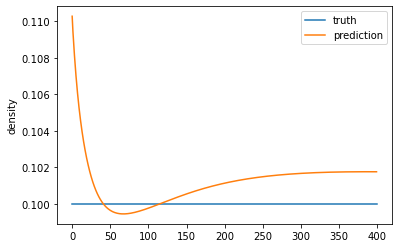

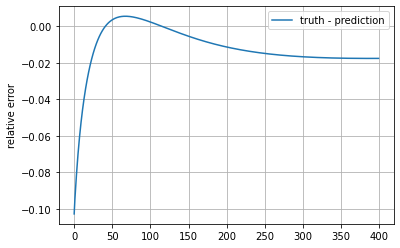

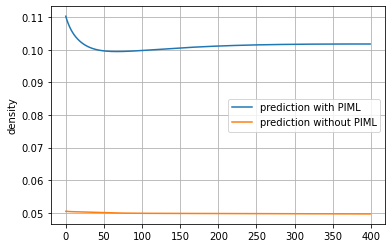

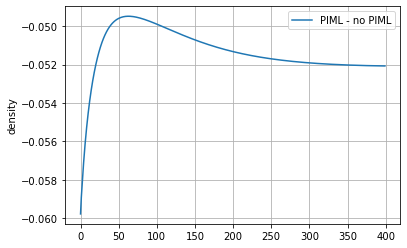

In [13]:
print('NVAR error: ', NVAR.get_error(test_run, norm='max') )


pred_PIML = NVAR.predict_single_run(test_run)


N_test = get_N(test_run)
N_pred = get_N(pred_PIML)

plt.plot(N_test, label='truth')
plt.plot(N_pred, label='prediction')
plt.legend()
plt.ylabel('density')
plt.show()

plt.grid()
plt.plot((N_test-N_pred)/N_test, label='truth - prediction')
plt.legend()
plt.ylabel('relative error')
plt.show()


plt.grid()
plt.plot(N_pred, label='prediction with PIML')
plt.plot(N_pred_noPI, label='prediction without PIML')
plt.legend()
plt.ylabel('density')
plt.show()

plt.grid()
plt.plot(N_pred_noPI-N_pred, label='PIML - no PIML')
plt.legend()
plt.ylabel('density')
plt.show()